# Predict polymers given a prompt

In [1]:
%reload_ext autoreload
%autoreload 2

import time
import matplotlib.pyplot as plt
plt.style.use(['science', 'nature'])
from pycm import ConfusionMatrix
import wandb
from sklearn.model_selection import train_test_split
import numpy as np

from gpt3forchem.polymers.data import get_data
from gpt3forchem.polymers.constants import TARGETS, FEATURES, CAT_TARGETS
from gpt3forchem.polymers.create_prompts import create_single_property_inverse_prompts
from gpt3forchem.fine_tune import fine_tune
from gpt3forchem.query_model import query_gpt3, extract_prediction

In [2]:
data = get_data()

In [3]:
train_df, test_df = train_test_split(data, train_size=0.9)

In [4]:
train_size = len(train_df)
test_size = len(test_df)
print(f"{len(train_df)} train points and {len(test_df)} test points")


2812 train points and 313 test points


In [25]:
train_prompts = create_single_property_inverse_prompts(train_df, CAT_TARGETS[0])
test_prompts = create_single_property_inverse_prompts(test_df, CAT_TARGETS[0])

In [26]:
train_prompts.head()

,prompt,completion
0,what is a polymer with 0 adsorption energy?###,B-R-R-R-A-R-R-W-R-A-B-B-R-A-A-W-A-W-R-R-W-A-A...
1,what is a polymer with 0 adsorption energy?###,A-W-W-B-R-B-B-W-R-A-B-B-W-W-B-A-W-R-A-B-B-W-R...
2,what is a polymer with 1 adsorption energy?###,A-R-B-A-R-R-B-A-B-R-A-B-R-R-B-R-B-R-B-R-W-W-B...
3,what is a polymer with 0 adsorption energy?###,W-R-B-B-W-R-W-W-A-R-A-A-R-A-W-R-A-R-R-A-A-R-B...
4,what is a polymer with 4 adsorption energy?###,W-R-B-A-R-W-W-R-A-B-R-W-A-R-W-W-W-W-W-B-R-W-B...


In [21]:
completion_lengths = []

for i, row in train_prompts.iterrows(): 
    completion_lengths.append(len(row['completion']))

completion_lengths = np.array(completion_lengths)

(array([ 24., 133., 159., 537., 359., 741., 548., 150., 137.,  24.]),
 array([35. , 41.4, 47.8, 54.2, 60.6, 67. , 73.4, 79.8, 86.2, 92.6, 99. ]),
 <BarContainer object of 10 artists>)

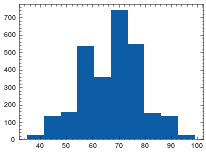

In [22]:
plt.hist(completion_lengths)

This is way longer than what we used for regression, but still much smaller than the maximum number of tokens (2048). However, it is longer than the default number of output tokens

In [24]:
np.mean(completion_lengths)

67.0398293029872

### Now, fine tune a model

In [29]:
filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = f"run_files/{filename_base}_train_inverse_prompts_polymers_{train_size}.jsonl"
valid_filename = f"run_files/{filename_base}_valid_inverse_prompts_polymers_{test_size}.jsonl"
# to save money, just run a small valid frame
valid_small_filename = f"run_files/{filename_base}_validsmall_inverse_prompts_polymers_{test_size}.jsonl"
train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)
test_prompts.sample(100).to_json(valid_small_filename, orient="records", lines=True)

In [30]:
fine_tune(train_filename, valid_small_filename) 

Upload progress: 100%|██████████| 402k/402k [00:00<00:00, 218Mit/s]


Uploaded file from run_files/2022-06-24-09-56-07_train_inverse_prompts_polymers_2812.jsonl: file-4ALR9IWrmcCYBFwg1SdasWxn


Upload progress: 100%|██████████| 14.2k/14.2k [00:00<00:00, 6.47Mit/s]


Uploaded file from run_files/2022-06-24-09-56-07_validsmall_inverse_prompts_polymers_313.jsonl: file-YUygyl5agZT2q8It4iIAspoy
Created fine-tune: ft-XmU0V1eMplRqymO94Okry8J2
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2022-06-24 10:18:18] Created fine-tune: ft-XmU0V1eMplRqymO94Okry8J2
[2022-06-24 10:20:03] Fine-tune costs $0.35
[2022-06-24 10:20:03] Fine-tune enqueued. Queue number: 12

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-XmU0V1eMplRqymO94Okry8J2

Fine-tune ft-XmU0V1eMplRqymO94Okry8J2 has the status "pending" and will not be logged
🎉 wandb sync completed successfully


In [47]:
completions = query_gpt3("ada:ft-epfl-2022-06-24-20-47-07", test_prompts.iloc[:2], max_tokens=100, temperature=1.2)


In [40]:
train_filename

'run_files/2022-06-24-09-56-07_train_inverse_prompts_polymers_2812.jsonl'

In [48]:
test_prompts

,prompt,completion
0,what is a polymer with 2 adsorption energy?###,R-A-A-W-B-R-A-B-R-B-W-A-W-B-W-R-R-R-A-B-A-B-W...
1,what is a polymer with 2 adsorption energy?###,A-W-B-B-A-W-A-W-R-R-A-B-B-B-R-A-A-B-R-A-W-W-B...
2,what is a polymer with 0 adsorption energy?###,R-R-B-A-B-R-A-R-R-R-R-A-B-W-R-W-B-R-R-W-W-A-A...
3,what is a polymer with 4 adsorption energy?###,B-R-W-R-B-B-W-B-A-R-R-W-B-R-W-W-W-B-A-A-W-W-B...
4,what is a polymer with 3 adsorption energy?###,W-A-W-B-W-B-B-B-R-R-B-B-W-A-B-R-W-W-B-R-A-W-B...
...,...,...
308,what is a polymer with 0 adsorption energy?###,W-W-W-W-A-W-W-B-A-A-B-A-R-A-A-R-A-R-B-W-R-W-A...
309,what is a polymer with 2 adsorption energy?###,W-B-R-A-R-W-R-W-W-B-B-R-A-W-R-R-A-W-B-R-B-B-W...
310,what is a polymer with 0 adsorption energy?###,B-A-B-B-A-R-A-R-A-W-B-A-A-A-R-B-W-A-B-R-B-W-R...
311,what is a polymer with 1 adsorption energy?###,A-R-R-B-B-A-B-R-B-A-R-R-A-W-A-B-W-W-A-A-R-A-B...


In [49]:
completions

[<OpenAIObject text_completion id=cmpl-5MxsQE6cMpFQG1UB6P2t1X5ZpRyXC at 0x2880bd130> JSON: {
   "choices": [
     {
       "finish_reason": "length",
       "index": 0,
       "logprobs": null,
       "text": " 4@@@@@@@@@@@@@@@@@@@@@@@@@@@@*** 3@@@@@@@@@@@@@@@-[\"@@@ forfeques@@@@@@@@@@@@@- endeavu@@- A- R- B### 3@@@@@@@ donkey@@@&@@@@@@- R- R- B- W- B- B- R- B### 1@@@@@@@@@@@"
     }
   ],
   "created": 1656155066,
   "id": "cmpl-5MxsQE6cMpFQG1UB6P2t1X5ZpRyXC",
   "model": "ada:ft-epfl-2022-06-24-20-47-07",
   "object": "text_completion",
   "usage": {
     "completion_tokens": 100,
     "prompt_tokens": 12,
     "total_tokens": 112
   }
 },
 <OpenAIObject text_completion id=cmpl-5MxsWByBeYawwUZXz21lFLjuM9Psz at 0x2892f9680> JSON: {
   "choices": [
     {
       "finish_reason": "length",
       "index": 0,
       "logprobs": null,
       "text": " 4@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@### 3@@@@@@@@@@@@@@@@@@@@ <@@@@@@@@@@@r@@@ engulfed-r-a-a-a-a-r-b-w-w-R-R-A-B-R-A### 0@@@@@@@@@

This didn't work at all.

Maybe we need to give more constraints. Let's try to but the composition into the prompt.

Again, I changed the defaults and it will now always put the desired composition into the prompt.

In [51]:
train_prompts = create_single_property_inverse_prompts(train_df, CAT_TARGETS[0])
test_prompts = create_single_property_inverse_prompts(test_df, CAT_TARGETS[0])

In [52]:
train_prompts

,prompt,completion
0,what is a polymer with 0 adsorption energy and...,B-R-R-R-A-R-R-W-R-A-B-B-R-A-A-W-A-W-R-R-W-A-A...
1,what is a polymer with 0 adsorption energy and...,A-W-W-B-R-B-B-W-R-A-B-B-W-W-B-A-W-R-A-B-B-W-R...
2,what is a polymer with 1 adsorption energy and...,A-R-B-A-R-R-B-A-B-R-A-B-R-R-B-R-B-R-B-R-W-W-B...
3,what is a polymer with 0 adsorption energy and...,W-R-B-B-W-R-W-W-A-R-A-A-R-A-W-R-A-R-R-A-A-R-B...
4,what is a polymer with 4 adsorption energy and...,W-R-B-A-R-W-W-R-A-B-R-W-A-R-W-W-W-W-W-B-R-W-B...
...,...,...
2807,what is a polymer with 0 adsorption energy and...,R-R-B-A-A-W-R-A-A-B-A-B-W-W-W-B-W-B-B-R-R-R-B...
2808,what is a polymer with 3 adsorption energy and...,B-R-W-A-B-W-R-W-R-W-W-A-R-B-R-A-B-R-A-B-B-W-R...
2809,what is a polymer with 0 adsorption energy and...,W-B-W-W-R-A-R-A-A-B-B-R-A-B-R-W-B-A-W-A-W-A-W...
2810,what is a polymer with 1 adsorption energy and...,W-B-W-B-R-A-A-B-W-A-A-R-W-B-A-W-A-R-W-B-R-R-R...


In [53]:
filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = f"run_files/{filename_base}_train_inverse_prompts_polymers_{train_size}.jsonl"
valid_filename = f"run_files/{filename_base}_valid_inverse_prompts_polymers_{test_size}.jsonl"
# to save money, just run a small valid frame
valid_small_filename = f"run_files/{filename_base}_validsmall_inverse_prompts_polymers_{test_size}.jsonl"
train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)
test_prompts.sample(100).to_json(valid_small_filename, orient="records", lines=True)

In [54]:
fine_tune(train_filename, valid_small_filename) 

Upload progress: 100%|██████████| 483k/483k [00:00<00:00, 184Mit/s]


Uploaded file from run_files/2022-06-25-17-15-56_train_inverse_prompts_polymers_2812.jsonl: file-vA5lcbvWWyDcftvv90LJ6RcH


Upload progress: 100%|██████████| 17.1k/17.1k [00:00<00:00, 30.5Mit/s]


Uploaded file from run_files/2022-06-25-17-15-56_validsmall_inverse_prompts_polymers_313.jsonl: file-aYymrjTSTbxtvfptHE7NCyXc
Created fine-tune: ft-FR643eTWPjn5nX8u6uobu2mt
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2022-06-25 17:16:42] Created fine-tune: ft-FR643eTWPjn5nX8u6uobu2mt
[2022-06-25 17:16:47] Fine-tune costs $0.41
[2022-06-25 17:16:48] Fine-tune enqueued. Queue number: 0
[2022-06-25 17:16:51] Fine-tune started
[2022-06-25 17:21:18] Completed epoch 1/4
[2022-06-25 17:25:29] Completed epoch 2/4
[2022-06-25 17:29:40] Completed epoch 3/4

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-FR643eTWPjn5nX8u6uobu2mt

Fine-tune ft-FR643eTWPjn5nX8u6uobu2mt has the status "running" and will not be logged
🎉 wandb sync completed successfully


In [55]:
completions = query_gpt3("ada:ft-epfl-2022-06-25-15-34-15", test_prompts.iloc[:2], max_tokens=100, temperature=1.2)


In [56]:
completions

[<OpenAIObject text_completion id=cmpl-5N2o0B0BRVTQnGutDLLwtAYBXgn7Y at 0x15828fc70> JSON: {
   "choices": [
     {
       "finish_reason": "length",
       "index": 0,
       "logprobs": null,
       "text": " R-W-A-R-A-B-B-R-A-W-R-A-B-R-A-R-B-W-R-R-R-B-B-W-W-W-B-B-B-W-A-W-A-W-B-B-B-W-A-R-B@@@@@@W-B@@@@@B@@R@@W@@R@@R"
     }
   ],
   "created": 1656174012,
   "id": "cmpl-5N2o0B0BRVTQnGutDLLwtAYBXgn7Y",
   "model": "ada:ft-epfl-2022-06-25-15-34-15",
   "object": "text_completion",
   "usage": {
     "completion_tokens": 100,
     "prompt_tokens": 25,
     "total_tokens": 125
   }
 },
 <OpenAIObject text_completion id=cmpl-5N2o8O0fFSYHb24QgsCNzlfDuwTMz at 0x177e4ec70> JSON: {
   "choices": [
     {
       "finish_reason": "length",
       "index": 0,
       "logprobs": null,
       "text": " W-R-A-B-R-A-A-B-W-A-R-A-A-B-W-B-W-A-W-A-B-B-W-A-B-B-A-B-R-A-R-W-R-B-A-W-R@@@@@B-W@@@@@A@@@@@A@@B@@@@@@@@@@@@@@@@@@@@@@"
     }
   ],
   "created": 1656174020,
   "id": "cmpl-5N2o8O0fFSYHb24QgsCNzlfD